# Digital Image Processing - Project - Deep Multi Task Learning for facial landmark recoginition #



### Authors - Aditya Menon, Arshad G, Ajit Jadhav, Paras Dahiya
#####                     Indian Institute of Information Technology, Sri City, AP

In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("preprocessed.csv")
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,image,x1,x2,x3,x4,x5,y1,y2,y3,y4,y5,gender,smile,glass,pose,map_to_img
2733,lfw_5590/Michael_McNeely_0001.jpg,64.3500,88.6500,75.45,67.05,88.3500,67.350000,64.950000,80.850000,93.750000,92.850000,1.0,2.0,2.0,3.0,2733
9713,net_7876/_-60_9871_0.jpg,62.8125,90.9375,67.50,63.75,83.4375,41.666667,42.361111,54.861111,67.361111,68.055556,1.0,2.0,2.0,3.0,9713
4737,net_7876/218_1_0.jpg,58.5000,97.1250,72.00,57.75,90.0000,55.875000,57.000000,73.500000,91.500000,93.375000,2.0,1.0,2.0,3.0,4737
7044,net_7876/8520_0_0.jpg,55.1250,96.0000,79.50,60.00,94.8750,55.875000,54.375000,84.000000,100.125000,97.875000,2.0,2.0,2.0,3.0,7044
2937,lfw_5590/Niall_Connolly_0001.jpg,64.0500,90.4500,73.05,64.05,83.2500,66.750000,70.950000,84.150000,92.550000,95.850000,1.0,2.0,2.0,3.0,2937


In [3]:
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [5]:
outputs = np.array(df)
yLandmark=outputs[:,1:11]
yGender=outputs[:,[11]]
ySmile=outputs[:,[12]]
yGlass=outputs[:,[13]]
yPose=outputs[:,[14]]
map_to_img = outputs[:,[15]].tolist()
map_to_img[0][0]


2733

In [6]:
enc.fit(yGender)
yGender=enc.transform(yGender).toarray()

enc.fit(ySmile)
ySmile=enc.transform(ySmile).toarray()

enc.fit(yGlass)
yGlass=enc.transform(yGlass).toarray()

enc.fit(yPose)
yPose=enc.transform(yPose).toarray()



In [7]:
yPose.tolist().count([0., 0., 0., 0., 0.])

0

In [8]:
def shared_model(X,istraining):
    
    x = tf.reshape(X,[-1,150,150,1])
    
    W1 = tf.get_variable("W1",shape=[5,5,1,16],initializer=tf.contrib.layers.xavier_initializer())
    B1 = tf.get_variable("B1",[16],initializer=tf.contrib.layers.xavier_initializer())
    
    L1 = tf.nn.conv2d(x,W1,strides=[1,1,1,1],padding='SAME')
    convL1 = tf.nn.elu(L1+B1)
    MP1 = tf.nn.max_pool(convL1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    W2 = tf.get_variable("W2",shape=[3,3,16,48],initializer=tf.contrib.layers.xavier_initializer())
    B2 = tf.get_variable("B2",[48],initializer=tf.contrib.layers.xavier_initializer())
    
    L2 = tf.nn.conv2d(MP1,W2,strides=[1,1,1,1],padding='SAME')
    convL2 = tf.nn.elu(L2+B2)
    
    convL2 = tf.contrib.layers.dropout(convL2,keep_prob=0.75,is_training=istraining);
    MP2 = tf.nn.max_pool(convL2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    
    W3 = tf.get_variable("W3",shape=[3,3,48,64],initializer=tf.contrib.layers.xavier_initializer())
    B3 = tf.get_variable("B3",[64],initializer=tf.contrib.layers.xavier_initializer())
    
    L3 = tf.nn.conv2d(MP2,W3,strides=[1,1,1,1],padding='SAME')
    convL3 = tf.nn.elu(L3+B3)
    
    convL3 = tf.contrib.layers.dropout(convL3,keep_prob=0.5,is_training=istraining)
    
    MP3 = tf.nn.max_pool(convL3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    W4 = tf.get_variable("W4",shape=[2,2,64,64],initializer=tf.contrib.layers.xavier_initializer())
    B4 = tf.get_variable("B4",[64],initializer=tf.contrib.layers.xavier_initializer())
    
    L4 = tf.nn.conv2d(MP3,W4,strides=[1,1,1,1],padding='SAME')
    
    
    convL4 = tf.nn.elu(L4+B4)
    
    convL4 = tf.contrib.layers.dropout(convL4,keep_prob=0.75,is_training=istraining)
    
    flat = tf.contrib.layers.flatten(convL4)
    sharedLayer = tf.contrib.layers.fully_connected(flat,100,activation_fn=None)
    
    #sharedLayer1 = tf.contrib.layers.batch_norm(sharedLayer)
    sharedLayer2 = tf.nn.elu(sharedLayer)
    
    return sharedLayer2
    
    
   

In [9]:
def landmark_model(X,istraining):
    
    W_l1 = tf.get_variable("W_l1",shape=[100,50],initializer=tf.contrib.layers.xavier_initializer())
    B_l1 = tf.get_variable("B_l1",shape=[50],initializer=tf.contrib.layers.xavier_initializer())
    
    lm_l1 = tf.matmul(X,W_l1) + B_l1
    
    Lm1 = tf.nn.relu(lm_l1)
    
    W_l2 = tf.get_variable("W_l2",shape=[50,10],initializer=tf.contrib.layers.xavier_initializer())
    B_l2 = tf.get_variable("B_l2",shape=[10],initializer=tf.contrib.layers.xavier_initializer())
    
    lm_l2 = tf.matmul(Lm1,W_l2) + B_l2
    
    return lm_l2

In [10]:
def gender_model(X,istraining):
    
    W_gender1 = tf.get_variable("W_gender1",shape=[100,50],initializer=tf.contrib.layers.xavier_initializer())
    B_gender1 = tf.get_variable("B_gender1",shape=[50],initializer=tf.contrib.layers.xavier_initializer())
    
    gender_l1 = tf.matmul(X,W_gender1) + B_gender1
    
    #Gender1_BN = tf.contrib.layers.batch_norm(gender_l1);
    
    Gender1_dropout = tf.contrib.layers.dropout(gender_l1,is_training=istraining)
    
    Gender1 = tf.nn.relu(gender_l1)
    
    
    W_gender2 = tf.get_variable("W_gender2",shape=[50,2],initializer=tf.contrib.layers.xavier_initializer())
    B_gender2 = tf.get_variable("B_gender2",shape=[2],initializer=tf.contrib.layers.xavier_initializer())
    
    gender_l2 = tf.matmul(Gender1,W_gender2) + B_gender2
    return gender_l2

In [11]:
def glass_model(X,istraining):
    
    W_glass1 = tf.get_variable("W_glass1",shape=[100,50],initializer=tf.contrib.layers.xavier_initializer())
    B_glass1 = tf.get_variable("B_glass1",shape=[50],initializer=tf.contrib.layers.xavier_initializer())
    
    glass_l1 = tf.matmul(X,W_glass1) + B_glass1
    
    Glass1_BN = tf.contrib.layers.batch_norm(glass_l1);
    Glass1 = tf.nn.elu(Glass1_BN)
    
    
    
    W_glass2 = tf.get_variable("W_glass2",shape=[50,2],initializer=tf.contrib.layers.xavier_initializer())
    B_glass2 = tf.get_variable("B_glass2",shape=[2],initializer=tf.contrib.layers.xavier_initializer())
    
    glass_l2 = tf.matmul(Glass1_BN,W_glass2) + B_glass2
        
    return glass_l2

In [12]:
def pose_model(X,istraining):
    
    W_pose1 = tf.get_variable("W_pose1",shape=[100,50],initializer=tf.contrib.layers.xavier_initializer())
    B_pose1 = tf.get_variable("B_pose1",shape=[50],initializer=tf.contrib.layers.xavier_initializer())
    
    pose_l1 = tf.matmul(X,W_pose1) + B_pose1
    
    Pose1 = tf.nn.relu(pose_l1)
    
    Pose1_BN = tf.contrib.layers.batch_norm(Pose1);
    
    W_pose2 = tf.get_variable("W_pose2",shape=[50,5],initializer=tf.contrib.layers.xavier_initializer())
    B_pose2 = tf.get_variable("B_pose2",shape=[5],initializer=tf.contrib.layers.xavier_initializer())
    
    pose_l2 = tf.matmul(Pose1_BN,W_pose2) + B_pose2
    
    return pose_l2

In [13]:
def smile_model(X,istraining):
    
    W_smile1 = tf.get_variable("W_smile1",shape=[100,50],initializer=tf.contrib.layers.xavier_initializer())
    B_smile1 = tf.get_variable("B_smile1",shape=[50],initializer=tf.contrib.layers.xavier_initializer())
    
    smile_l1 = tf.matmul(X,W_smile1) + B_smile1
    
    Smile1 = tf.nn.relu(smile_l1)
    
    Smile1_BN = tf.contrib.layers.batch_norm(Smile1);
    Smile1_dropout = tf.contrib.layers.batch_norm(Smile1_BN);
    
    
    W_smile2 = tf.get_variable("W_smile2",shape=[50,2],initializer=tf.contrib.layers.xavier_initializer())
    B_smile2 = tf.get_variable("B_smile2",shape=[2],initializer=tf.contrib.layers.xavier_initializer())
    
    smile_l2 = tf.matmul(Smile1_dropout,W_smile2) + B_smile2
    
    
    return smile_l2

In [14]:
def landmarkLoss(ypred,y):
    return tf.reduce_mean(tf.square(ypred - y))/2

In [15]:
def genderLoss(ypred,y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ypred,labels=y))

In [16]:
def glassLoss(ypred,y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ypred,labels=y))

In [17]:
def poseLoss(ypred,y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ypred,labels=y))

In [18]:
def smileLoss(ypred,y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ypred,labels=y))

In [19]:
tf.reset_default_graph()
X = tf.placeholder("float")
istraining = tf.placeholder("bool")
yLm = tf.placeholder("float")
yGd = tf.placeholder("float")
yGl = tf.placeholder("float")
yP = tf.placeholder("float")
ySml = tf.placeholder("float")

In [20]:
images = np.load("image_details.npy")
images = images[df['map_to_img'].tolist()]
images[:2]

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [203, 205, 210, ...,  61,  61,  64],
        [203, 206, 211, ...,  60,  60,  62],
        [203, 206, 212, ...,  63,  59,  59]],

       [[178, 179, 180, ..., 190, 188, 187],
        [179, 181, 182, ..., 189, 189, 189],
        [180, 182, 183, ..., 188, 190, 191],
        ...,
        [157, 160, 163, ..., 121, 118, 128],
        [159, 159, 161, ..., 136, 134, 143],
        [164, 162, 160, ..., 154, 145, 146]]], dtype=uint8)

In [21]:
sharedLayer = shared_model(X,istraining)
yLandmarkPred = landmark_model(sharedLayer,istraining)
yGenderPred = gender_model(sharedLayer,istraining)
ySmilePred = smile_model(sharedLayer,istraining)
yGlassPred = glass_model(sharedLayer,istraining)
yPosePred = pose_model(sharedLayer,istraining)

In [22]:
def train():   
    gd_loss = genderLoss(yGenderPred,yGd)
    lm_loss = landmarkLoss(yLandmarkPred,yLm)
    sml_loss = smileLoss(ySmilePred,ySml)
    gl_loss = glassLoss(yGlassPred,yGl)
    p_loss=poseLoss(yPosePred,yP)
    
    
    total_loss = ( lm_loss + gd_loss + sml_loss + gl_loss + p_loss )
    
    total_loss_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(total_loss)
    gd_loss_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(gd_loss)
    lm_loss_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(lm_loss)
    gl_loss_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(gl_loss)
    p_loss_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(p_loss)
    
    epochs = 10
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        print("Started training ....")
        initializer = tf.global_variables_initializer()
        sess.run(initializer)
       
        for epoch in range(epochs):
            epoch_loss = 0
            
            #batch_size=100
            
            acc = 0
            i = 0
            for _ in range(100):
                img = images[i:i+80];
                img = np.reshape(img,[80,150,150,1])
                #fd = {X:img,yLm:yLandmark[i],yGd:yGender[i],ySml:ySmile[i],yGl:yGlass[i],yP:yPose[i]} 
                fd = {X:img,yGd:yGender[i:i+80],yGl:yGlass[i:i+80],ySml:ySmile[i:i+80],yP:yPose[i:i+80],yLm:yLandmark[i:i+80],istraining:True}
                 
                loss , opt = sess.run([total_loss,total_loss_optimizer],feed_dict=fd)
                
                epoch_loss += loss
                
        
                #print(tf.cast(yGenderPred,'float').eval({X:np.reshape(images[i],[1,150,150,1]),yGd:yGender[i]}))
                i = i+80
                
            gender_acc = 0
            glass_acc = 0
            smile_acc = 0
            pose_acc = 0
            
#             for j in range(0,8000,100):
#                 landmark_loss = tf.cast(tf.reduce_mean(tf.square(yLandmarkPred-yLm))/2,'float').eval({X:np.reshape(images[j:j+100],[100,150,150,1]),yLm:yLandmark[j:j+100],istraining:False})
                
#                 gender_correct = tf.equal(tf.argmax(yGenderPred,1),tf.argmax(yGd,1))
#                 gender_accuracy = tf.reduce_mean(tf.cast(gender_correct,'float'))
#                 gender_acc += gender_accuracy.eval({X:np.reshape(images[j:j+100],[100,150,150,1]),yGd:yGender[j:j+100],istraining:False})
                
                
#                 glass_correct = tf.equal(tf.argmax(yGlassPred,1),tf.argmax(yGl,1))
#                 glass_accuracy = tf.reduce_mean(tf.cast(glass_correct,'float'))
#                 glass_acc += glass_accuracy.eval({X:np.reshape(images[j:j+100],[100,150,150,1]),yGl:yGlass[j:j+100],istraining:False})
                
                
#                 smile_correct = tf.equal(tf.argmax(ySmilePred,1),tf.argmax(ySml,1))
#                 smile_accuracy = tf.reduce_mean(tf.cast(smile_correct,'float'))
#                 smile_acc += smile_accuracy.eval({X:np.reshape(images[j:j+100],[100,150,150,1]),ySml:ySmile[j:j+100],istraining:False})
                
                
#                 pose_correct = tf.equal(tf.argmax(yPosePred,1),tf.argmax(yP,1))
#                 pose_accuracy = tf.reduce_mean(tf.cast(pose_correct,'float'))
#                 pose_acc += pose_accuracy.eval({X:np.reshape(images[j:j+100],[100,150,150,1]),yP:yPose[j:j+100],istraining:False})
            
            print('epoch',epoch+1,'completed out of',epochs,'loss:',epoch_loss,"i =",i)
#             print('training set accuracy')
#             print('gender acc = ', gender_acc/80)
#             print('smile acc = ', smile_acc/80)
#             print('pose acc = ', pose_acc/80)
#             print('glass acc = ', glass_acc/80)
            
#             print('Landmark loss',landmark_loss/80)

            it = 8000
            
            gender_acc = 0
            glass_acc = 0
            smile_acc = 0
            pose_acc = 0
            landmark_loss = 0
            
            for e in range(20):
                landmark_loss += tf.cast(tf.reduce_mean(tf.square(yLandmarkPred-yLm))/2,'float').eval({X:np.reshape(images[it:it+100],[100,150,150,1]),yLm:yLandmark[it:it+100],istraining:False})
                
                gender_correct = tf.equal(tf.argmax(yGenderPred,1),tf.argmax(yGd,1))
                gender_accuracy = tf.reduce_mean(tf.cast(gender_correct,'float'))
                gender_acc += gender_accuracy.eval({X:np.reshape(images[it:it+100],[100,150,150,1]),yGd:yGender[it:it+100],istraining:False})
                
                
                glass_correct = tf.equal(tf.argmax(yGlassPred,1),tf.argmax(yGl,1))
                glass_accuracy = tf.reduce_mean(tf.cast(glass_correct,'float'))
                glass_acc += glass_accuracy.eval({X:np.reshape(images[it:it+100],[100,150,150,1]),yGl:yGlass[it:it+100],istraining:False})
                
                
                smile_correct = tf.equal(tf.argmax(ySmilePred,1),tf.argmax(ySml,1))
                smile_accuracy = tf.reduce_mean(tf.cast(smile_correct,'float'))
                smile_acc += smile_accuracy.eval({X:np.reshape(images[it:it+100],[100,150,150,1]),ySml:ySmile[it:it+100],istraining:False})
                
                
                pose_correct = tf.equal(tf.argmax(yPosePred,1),tf.argmax(yP,1))
                pose_accuracy = tf.reduce_mean(tf.cast(pose_correct,'float'))
                pose_acc += pose_accuracy.eval({X:np.reshape(images[it:it+100],[100,150,150,1]),yP:yPose[it:it+100],istraining:False})
                it+=100
            print('cross validation set accuracy')
            print('gender acc = ', gender_acc/20)
            print('smile acc = ', smile_acc/20)
            print('pose acc = ', pose_acc/20)
            print('glass acc = ', glass_acc/20)
            
            print('Landmark loss',landmark_loss/20)
            print('------------------------------------------------------------------------------------------------')
#         print(yGenderPred.shape,yGender.shape)
#         print(correct.eval({X:np.reshape(images[:100],[100,150,150,1]),yLm:yLandmark[:100],yGd:yGender[:100],ySml:ySmile[:100],yGl:yGlass[:100],yP:yPose[:100]}))
#         print("test")

        save_path = saver.save(sess,"./model.ckpt")
    
        
        
    
    
    

In [23]:
def predict(img):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess,"./model.ckpt")
        
        fd = {X:np.reshape(img,[1,150,150,1]),istraining:False}
        landmark = tf.cast(yLandmarkPred,'float').eval(fd)
        gender = tf.cast(tf.argmax(yGenderPred,1),'float').eval(fd)
        glass = tf.cast(tf.argmax(yGlassPred,1),'float').eval(fd)
        smile = tf.cast(tf.argmax(ySmilePred,1),'float').eval(fd)
        pose = tf.cast(tf.argmax(yPosePred,1),'float').eval(fd)
        
        
        if(gender==[0]):
            gender = 'Male'
        else:
            gender = 'Female'
            
            
        if(glass == [0]):
            glass = 'True'
        else:
            glass = 'False'
            
            
        if(smile==[0]):
            smile = 'True'
        else:
            smile = 'False'
            
            
        if(pose == [0]):
            pose = 'Left Profile'
        elif(pose == [1]):
            pose ='Left'
        elif(pose == [2]):
            pose = 'Frontal'
        elif(pose == [3]):
            pose ='Right'
        else:
            pose = 'Right Profile'
        
        return {'landmark': landmark,
                'gender' : gender,
                'glass' : glass,
                'smile' : smile,
                'pose' : pose
                }        

In [24]:
train()

Started training ....
epoch 1 completed out of 10 loss: 35579.70487976074 i = 8000
cross validation set accuracy
gender acc =  0.5849999964237214
smile acc =  0.5469999969005584
pose acc =  0.6044999957084656
glass acc =  0.7425000011920929
Landmark loss 46.42398548126221
------------------------------------------------------------------------------------------------
epoch 2 completed out of 10 loss: 2419.403419494629 i = 8000
cross validation set accuracy
gender acc =  0.5879999965429306
smile acc =  0.5599999994039535
pose acc =  0.7265000015497207
glass acc =  0.8285000026226044
Landmark loss 23.07556095123291
------------------------------------------------------------------------------------------------
epoch 3 completed out of 10 loss: 1614.6409225463867 i = 8000
cross validation set accuracy
gender acc =  0.6060000032186508
smile acc =  0.6375000029802322
pose acc =  0.7379999995231629
glass acc =  0.8550000011920929
Landmark loss 14.341171836853027
-----------------------------

In [37]:
cap = cv.VideoCapture(0)
face_cascade = cv.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
# eye_cascade = cv.CascadeClassifier('../haarcascades/haarcascade_eye.xml')

In [38]:
while(True):
    ret, img = cap.read()
    #print(ret,img)
    gray = img    
    dat=''
    data = ''
    gray = cv.cvtColor(gray, cv.COLOR_BGR2GRAY);
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#     print()
    for (x,y,w,h) in faces:
        cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
#         eyes = eye_cascade.detectMultiScale(roi_gray)
#         for (ex,ey,ew,eh) in eyes:
#             cv.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        data = predict(cv.resize(roi_gray,(150,150),interpolation = cv.INTER_AREA))
#         if data['gender']==0:
#             dat = 'male'
#         else:
#             dat = 'female'
        
    cv.putText(img,str(dat)+str(data),(0, 50),cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1, cv.LINE_AA)
    cv.imshow('frame',img)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

cv.destroyAllWindows()
cv.waitKey(1)

INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt


-1

In [36]:
cap.release()

cv.destroyAllWindows()
cv.waitKey(1)

113

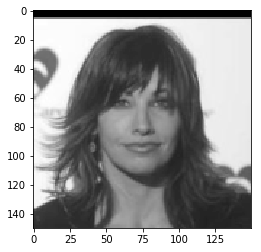

In [50]:
plt.imshow(images[8679],cmap='gray')

In [49]:
df.iloc[8679]

image         lfw_5590/Gina_Gershon_0001.jpg
x1                                     61.65
x2                                     88.05
x3                                     76.05
x4                                     63.75
x5                                     87.75
y1                                     64.35
y2                                     64.35
y3                                     82.05
y4                                     93.75
y5                                     93.15
gender                                     2
smile                                      1
glass                                      2
pose                                       3
map_to_img                              1388
Name: 1388, dtype: object

In [51]:
predict(images[8679])

INFO:tensorflow:Restoring parameters from ./model.ckpt


{'gender': 'Female',
 'glass': 'False',
 'landmark': array([[59.22827 , 87.499794, 75.71449 , 63.230324, 86.92218 , 62.952698,
         62.371204, 77.18699 , 90.9555  , 90.212006]], dtype=float32),
 'pose': 'Frontal',
 'smile': 'True'}

In [46]:
landmark = predict(images[8679])['landmark'][0].tolist()

INFO:tensorflow:Restoring parameters from ./model.ckpt


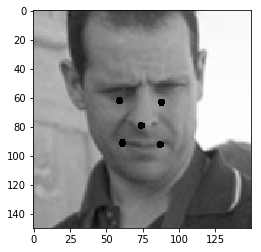

In [48]:
cv.circle(images[8678],(int(landmark[0]),int(landmark[5])),1,(0,0,255),2)
cv.circle(images[8678],(int(landmark[1]),int(landmark[6])),1,(0,0,255),2)
cv.circle(images[8678],(int(landmark[2]),int(landmark[7])),1,(0,0,255),2)
cv.circle(images[8678],(int(landmark[3]),int(landmark[8])),1,(0,0,255),2)
cv.circle(images[8678],(int(landmark[4]),int(landmark[9])),1,(0,0,255),2)
plt.imshow(images[8678],cmap='gray')